# CM3070 - Final Project
## CM3015- Template 1: Deep Learning on a public dataset  

For the second part we will retrain the model using only the label if the image has deforestation or not.

To train the model I create a new column in the `csv` with the name `has_deforestation`, if the labels column has any of these labels below the new column is true, if it has none is false.
- `agriculture`
- `cultivation`
- `road`
- `convetional_mine`
- `artisinal_mine`
- `slash_burn`
- `bare_ground`
- `sellective_logging`
- `habbitation`

In [1]:
from fastai.vision.all import *

In [2]:
image_type = 'jpg'

In [3]:
train_label = pd.read_csv('datasets/train/train_treated.csv')

In [4]:
dls = ImageDataLoaders.from_df(train_label, folder=f'datasets/train/{image_type}/', suff='.' + image_type, bs=16)

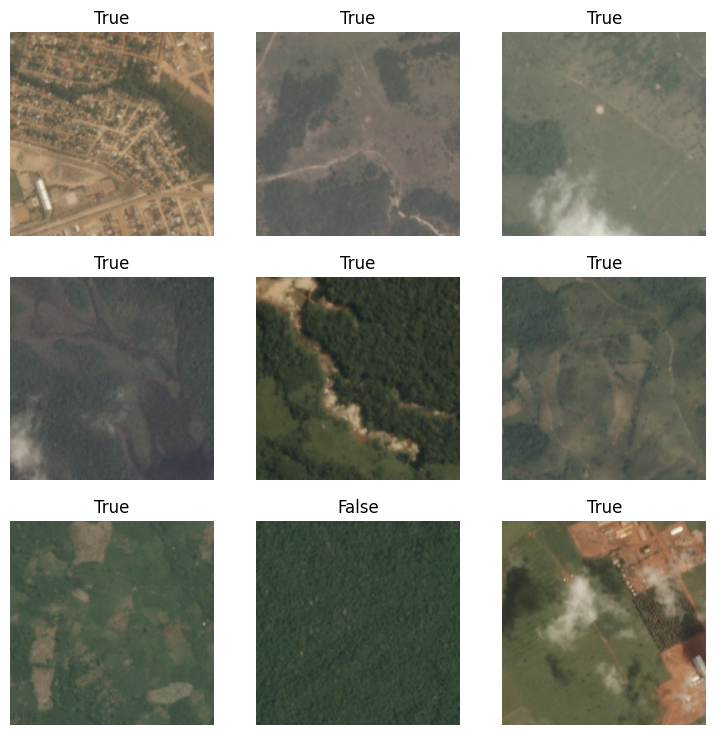

In [5]:
dls.show_batch()

## Generating the model
We will use a residual network with 50 layers in our model.

For a single label model the accuracy is the best predictor.

In [6]:
learn = vision_learner(dls, resnet50, metrics=error_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0030199517495930195)

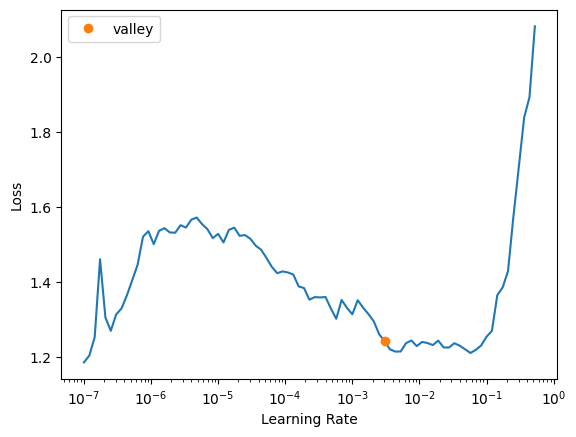

In [7]:
learn.lr_find()

In [8]:
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.319667,0.231243,0.090303,07:32


epoch,train_loss,valid_loss,error_rate,time
0,0.231080,0.200812,0.076096,10:27
1,0.169230,0.174316,0.066584,10:26


## Model result

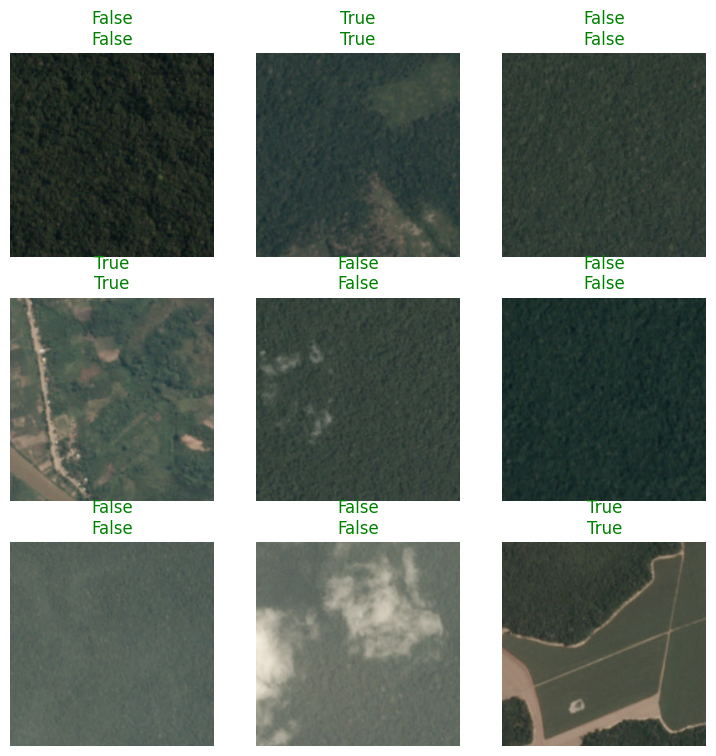

In [9]:
learn.show_results()

In [10]:
interp = Interpretation.from_learner(learn)

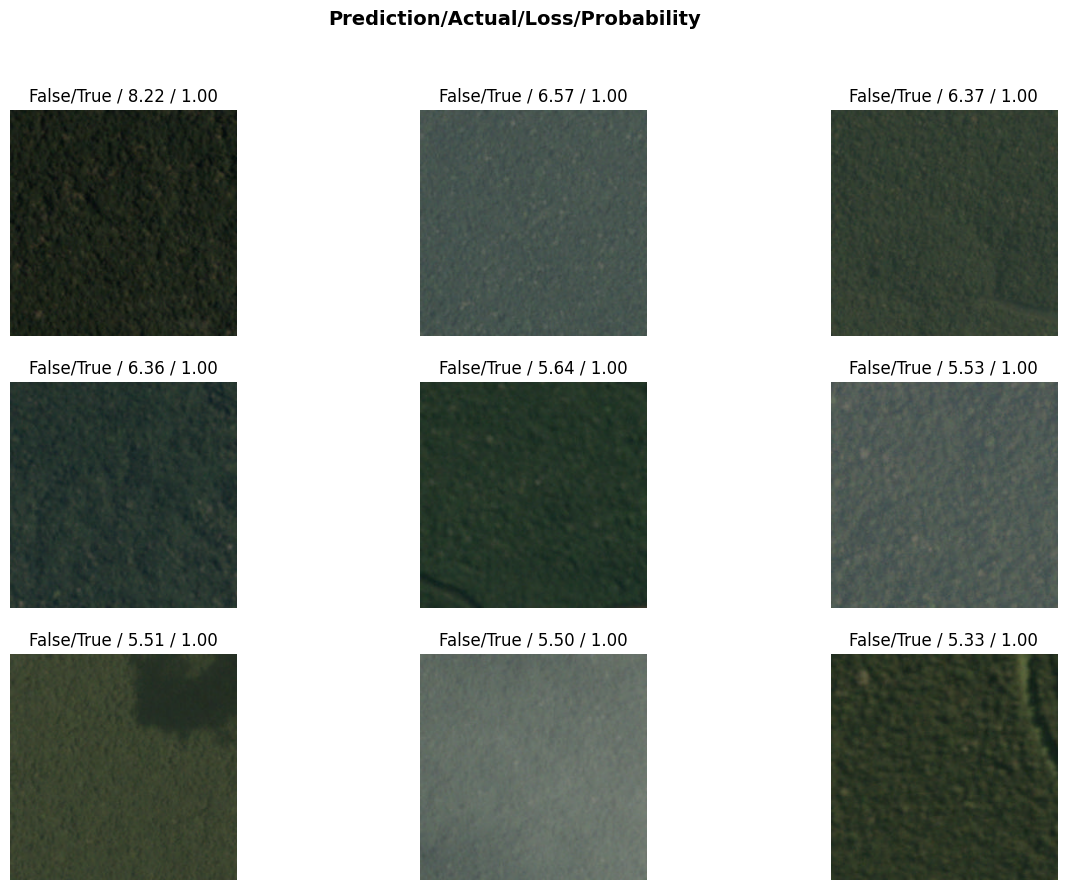

In [11]:
interp.plot_top_losses(9, figsize=(15,10))

## Sample prediction

In [12]:
learn.predict('datasets/train/jpg/train_0.jpg')

('False', tensor(0), tensor([0.9955, 0.0045]))

## Saving the model for future use

In [13]:
learn.save('single-rn50')

Path('models/single-rn50.pth')

In [14]:
torch.save(learn.model, "models/single-rn50.pt") 

In [15]:
test_files = get_image_files('datasets/external')

In [16]:
test_dl = learn.dls.test_dl(test_files)

In [17]:
probs, _ = learn.get_preds(dl=test_dl)

## Testing with external data

In [18]:
learn.predict('datasets/external/LC08_L1TP_228064_20230811_20230818_02_T1_4096_1024.jpg')

('True', tensor(1), tensor([0.0120, 0.9880]))

The model predicted that the image had deforestation and it has.

![image](datasets/external/LC08_L1TP_228064_20230811_20230818_02_T1_4096_1024.jpg)

In [19]:
threshold = 0.5

In [20]:
predicted_has_deforestation = [pred[1] > threshold for pred in probs.numpy()]

In [21]:
df = pd.DataFrame({
    'image_name': [f.name.split('.')[0] for f in test_files],
    'has_deforestation': predicted_has_deforestation
})

In [22]:
df.to_csv('predictions_single.csv', index=False)